# Method 3 - Best Ideas High Minus Low Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
low_ideas = best_ideas[best_ideas['size_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['size_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

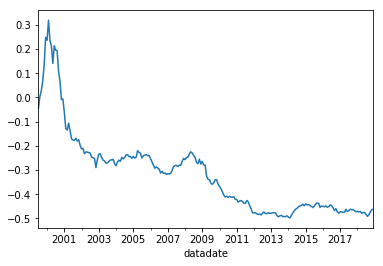

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.248712
2000-12-31   -0.203881
2001-12-31   -0.192912
2002-12-31   -0.073806
2003-12-31   -0.022453
2004-12-31    0.030465
2005-12-31    0.015924
2006-12-31   -0.102775
2007-12-31    0.095897
2008-12-31   -0.030921
2009-12-31   -0.114319
2010-12-31   -0.098255
2011-12-31   -0.096124
2012-12-31   -0.004359
2013-12-31   -0.019354
2014-12-31    0.082297
2015-12-31   -0.003157
2016-12-31   -0.053487
2017-12-31    0.011752
2018-12-31    0.020267
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     14.31
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.91e-10
Time:                        13:19:27   Log-Likelihood:                 597.74
No. Observations:                 234   AIC:                            -1185.
Df Residuals:                     229   BIC:                            -1168.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.001     -1.386      0.167      -0.004       0.001
mktrf         -0.0011      0.035     -0.031      0.975      -0.071       0.069
me            -0.0092      0.041     -0.223      0.824      -0.090       0.072
ia            -0.4692      0.063     -7.484      0.000      -0.593      -0.346
roe            0.0982      0.054      1.831      0.068      -0.007       0.204
==============================================================================
Omnibus:                       21.496   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.511
Skew:                          -0.063   Prob(JB):                     2.70e-19
Kurtosis:                       5.959   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     15.31
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.11e-11
Time:                        13:19:27   Log-Likelihood:                 597.74
No. Observations:                 234   AIC:                            -1185.
Df Residuals:                     229   BIC:                            -1168.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.002     -1.094      0.274      -0.005       0.001
mktrf         -0.0011      0.049     -0.022      0.982      -0.097       0.095
me            -0.0092      0.115     -0.080      0.936      -0.235       0.216
ia            -0.4692      0.130     -3.603      0.000      -0.724      -0.214
roe            0.0982      0.072      1.365      0.172      -0.043       0.239
==============================================================================
Omnibus:                       21.496   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.511
Skew:                          -0.063   Prob(JB):                     2.70e-19
Kurtosis:                       5.959   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     20.52
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.82e-14
Time:                        13:19:27   Log-Likelihood:                 597.74
No. Observations:                 234   AIC:                            -1185.
Df Residuals:                     229   BIC:                            -1168.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.002     -1.162      0.245      -0.005       0.001
mktrf         -0.0011      0.042     -0.026      0.979      -0.083       0.081
me            -0.0092      0.113     -0.081      0.935      -0.231       0.213
ia            -0.4692      0.143     -3.283      0.001      -0.749      -0.189
roe            0.0982      0.069      1.427      0.154      -0.037       0.233
==============================================================================
Omnibus:                       21.496   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.511
Skew:                          -0.063   Prob(JB):                     2.70e-19
Kurtosis:                       5.959   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     15.81
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.30e-13
Time:                        13:19:27   Log-Likelihood:                 606.46
No. Observations:                 234   AIC:                            -1201.
Df Residuals:                     228   BIC:                            -1180.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.521      0.603      -0.003       0.002
mktrf         -0.0494      0.034     -1.441      0.151      -0.117       0.018
smb           -0.0895      0.045     -1.977      0.049      -0.179      -0.000
hml           -0.2293      0.053     -4.297      0.000      -0.335      -0.124
rmw           -0.1404      0.060     -2.326      0.021      -0.259      -0.021
cma           -0.0941      0.077     -1.227      0.221      -0.245       0.057
==============================================================================
Omnibus:                       18.640   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.649
Skew:                          -0.019   Prob(JB):                     9.15e-15
Kurtosis:                       5.575   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     18.73
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.37e-15
Time:                        13:19:27   Log-Likelihood:                 606.46
No. Observations:                 234   AIC:                            -1201.
Df Residuals:                     228   BIC:                            -1180.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.460      0.645      -0.003       0.002
mktrf         -0.0494      0.038     -1.315      0.189      -0.123       0.024
smb           -0.0895      0.093     -0.962      0.336      -0.272       0.093
hml           -0.2293      0.071     -3.237      0.001      -0.368      -0.090
rmw           -0.1404      0.091     -1.544      0.123      -0.319       0.038
cma           -0.0941      0.128     -0.737      0.461      -0.345       0.156
==============================================================================
Omnibus:                       18.640   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.649
Skew:                          -0.019   Prob(JB):                     9.15e-15
Kurtosis:                       5.575   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     30.93
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.62e-24
Time:                        13:19:27   Log-Likelihood:                 606.46
No. Observations:                 234   AIC:                            -1201.
Df Residuals:                     228   BIC:                            -1180.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.481      0.630      -0.003       0.002
mktrf         -0.0494      0.035     -1.393      0.164      -0.119       0.020
smb           -0.0895      0.081     -1.105      0.269      -0.248       0.069
hml           -0.2293      0.076     -3.025      0.002      -0.378      -0.081
rmw           -0.1404      0.099     -1.417      0.156      -0.334       0.054
cma           -0.0941      0.124     -0.757      0.449      -0.338       0.150
==============================================================================
Omnibus:                       18.640   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.649
Skew:                          -0.019   Prob(JB):                     9.15e-15
Kurtosis:                       5.575   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     28.67
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.54e-19
Time:                        13:19:27   Log-Likelihood:                 619.13
No. Observations:                 234   AIC:                            -1228.
Df Residuals:                     229   BIC:                            -1211.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.001     -2.262      0.025      -0.005      -0.000
mktrf          0.0690      0.030      2.316      0.021       0.010       0.128
smb           -0.0738      0.037     -1.983      0.049      -0.147      -0.000
hml           -0.2868      0.037     -7.761      0.000      -0.360      -0.214
umd            0.1436      0.024      5.924      0.000       0.096       0.191
==============================================================================
Omnibus:                        6.178   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                9.200
Skew:                           0.087   Prob(JB):                       0.0101
Kurtosis:                       3.956   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     9.757
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.64e-07
Time:                        13:19:27   Log-Likelihood:                 619.13
No. Observations:                 234   AIC:                            -1228.
Df Residuals:                     229   BIC:                            -1211.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.001     -2.124      0.034      -0.005      -0.000
mktrf          0.0690      0.046      1.502      0.133      -0.021       0.159
smb           -0.0738      0.074     -1.000      0.317      -0.218       0.071
hml           -0.2868      0.067     -4.268      0.000      -0.418      -0.155
umd            0.1436      0.039      3.700      0.000       0.068       0.220
==============================================================================
Omnibus:                        6.178   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                9.200
Skew:                           0.087   Prob(JB):                       0.0101
Kurtosis:                       3.956   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     8.435
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.30e-06
Time:                        13:19:27   Log-Likelihood:                 619.13
No. Observations:                 234   AIC:                            -1228.
Df Residuals:                     229   BIC:                            -1211.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.001     -2.125      0.034      -0.005      -0.000
mktrf          0.0690      0.049      1.398      0.162      -0.028       0.166
smb           -0.0738      0.064     -1.152      0.249      -0.199       0.052
hml           -0.2868      0.078     -3.664      0.000      -0.440      -0.133
umd            0.1436      0.043      3.320      0.001       0.059       0.228
==============================================================================
Omnibus:                        6.178   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                9.200
Skew:                           0.087   Prob(JB):                       0.0101
Kurtosis:                       3.956   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     10.33
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.52e-07
Time:                        13:19:27   Log-Likelihood:                 282.48
No. Observations:                 120   AIC:                            -555.0
Df Residuals:                     115   BIC:                            -541.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.002     -1.097      0.275      -0.007       0.002
mktrf          0.0310      0.061      0.513      0.609      -0.089       0.151
me             0.0765      0.060      1.280      0.203      -0.042       0.195
ia            -0.5763      0.094     -6.157      0.000      -0.762      -0.391
roe            0.1652      0.083      1.994      0.049       0.001       0.329
==============================================================================
Omnibus:                        6.386   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                8.399
Skew:                          -0.254   Prob(JB):                       0.0150
Kurtosis:                       4.193   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     12.20
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.66e-08
Time:                        13:19:27   Log-Likelihood:                 282.48
No. Observations:                 120   AIC:                            -555.0
Df Residuals:                     115   BIC:                            -541.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.003     -0.896      0.370      -0.008       0.003
mktrf          0.0310      0.076      0.410      0.682      -0.117       0.179
me             0.0765      0.119      0.643      0.520      -0.157       0.310
ia            -0.5763      0.141     -4.092      0.000      -0.852      -0.300
roe            0.1652      0.104      1.595      0.111      -0.038       0.368
==============================================================================
Omnibus:                        6.386   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                8.399
Skew:                          -0.254   Prob(JB):                       0.0150
Kurtosis:                       4.193   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     14.48
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.32e-09
Time:                        13:19:27   Log-Likelihood:                 282.48
No. Observations:                 120   AIC:                            -555.0
Df Residuals:                     115   BIC:                            -541.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.003     -0.954      0.340      -0.008       0.003
mktrf          0.0310      0.071      0.437      0.662      -0.108       0.170
me             0.0765      0.120      0.637      0.524      -0.159       0.312
ia            -0.5763      0.151     -3.812      0.000      -0.873      -0.280
roe            0.1652      0.101      1.635      0.102      -0.033       0.363
==============================================================================
Omnibus:                        6.386   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                8.399
Skew:                          -0.254   Prob(JB):                       0.0150
Kurtosis:                       4.193   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     9.723
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.36e-08
Time:                        13:19:27   Log-Likelihood:                 285.38
No. Observations:                 120   AIC:                            -558.8
Df Residuals:                     114   BIC:                            -542.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.174      0.862      -0.005       0.004
mktrf         -0.0630      0.063     -1.007      0.316      -0.187       0.061
smb           -0.0374      0.071     -0.527      0.599      -0.178       0.103
hml           -0.2448      0.087     -2.820      0.006      -0.417      -0.073
rmw           -0.1401      0.102     -1.368      0.174      -0.343       0.063
cma           -0.1431      0.112     -1.276      0.205      -0.365       0.079
==============================================================================
Omnibus:                        6.586   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                9.011
Skew:                          -0.245   Prob(JB):                       0.0110
Kurtosis:                       4.250   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     8.223
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.16e-06
Time:                        13:19:28   Log-Likelihood:                 285.38
No. Observations:                 120   AIC:                            -558.8
Df Residuals:                     114   BIC:                            -542.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.159      0.874      -0.005       0.004
mktrf         -0.0630      0.062     -1.024      0.306      -0.184       0.058
smb           -0.0374      0.120     -0.311      0.756      -0.273       0.198
hml           -0.2448      0.085     -2.874      0.004      -0.412      -0.078
rmw           -0.1401      0.106     -1.318      0.188      -0.348       0.068
cma           -0.1431      0.177     -0.809      0.418      -0.490       0.204
==============================================================================
Omnibus:                        6.586   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                9.011
Skew:                          -0.245   Prob(JB):                       0.0110
Kurtosis:                       4.250   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     11.24
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.02e-09
Time:                        13:19:28   Log-Likelihood:                 285.38
No. Observations:                 120   AIC:                            -558.8
Df Residuals:                     114   BIC:                            -542.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.169      0.866      -0.005       0.004
mktrf         -0.0630      0.057     -1.097      0.273      -0.176       0.050
smb           -0.0374      0.101     -0.370      0.711      -0.235       0.160
hml           -0.2448      0.090     -2.732      0.006      -0.420      -0.069
rmw           -0.1401      0.104     -1.341      0.180      -0.345       0.065
cma           -0.1431      0.177     -0.810      0.418      -0.489       0.203
==============================================================================
Omnibus:                        6.586   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                9.011
Skew:                          -0.245   Prob(JB):                       0.0110
Kurtosis:                       4.250   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     25.18
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.43e-15
Time:                        13:19:28   Log-Likelihood:                 301.82
No. Observations:                 120   AIC:                            -593.6
Df Residuals:                     115   BIC:                            -579.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.002     -1.230      0.221      -0.006       0.001
mktrf          0.1480      0.045      3.260      0.001       0.058       0.238
smb           -0.0714      0.052     -1.381      0.170      -0.174       0.031
hml           -0.3229      0.052     -6.240      0.000      -0.425      -0.220
umd            0.2024      0.032      6.345      0.000       0.139       0.266
==============================================================================
Omnibus:                        0.044   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.978   Jarque-Bera (JB):                0.186
Skew:                           0.013   Prob(JB):                        0.911
Kurtosis:                       2.809   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     8.633
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.96e-06
Time:                        13:19:28   Log-Likelihood:                 301.82
No. Observations:                 120   AIC:                            -593.6
Df Residuals:                     115   BIC:                            -579.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.002     -1.471      0.141      -0.005       0.001
mktrf          0.1480      0.057      2.612      0.009       0.037       0.259
smb           -0.0714      0.075     -0.950      0.342      -0.219       0.076
hml           -0.3229      0.074     -4.369      0.000      -0.468      -0.178
umd            0.2024      0.038      5.260      0.000       0.127       0.278
==============================================================================
Omnibus:                        0.044   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.978   Jarque-Bera (JB):                0.186
Skew:                           0.013   Prob(JB):                        0.911
Kurtosis:                       2.809   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     6.686
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.12e-05
Time:                        13:19:28   Log-Likelihood:                 301.82
No. Observations:                 120   AIC:                            -593.6
Df Residuals:                     115   BIC:                            -579.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.001     -1.548      0.122      -0.005       0.001
mktrf          0.1480      0.055      2.700      0.007       0.041       0.255
smb           -0.0714      0.064     -1.111      0.267      -0.197       0.055
hml           -0.3229      0.082     -3.920      0.000      -0.484      -0.161
umd            0.2024      0.042      4.820      0.000       0.120       0.285
==============================================================================
Omnibus:                        0.044   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.978   Jarque-Bera (JB):                0.186
Skew:                           0.013   Prob(JB):                        0.911
Kurtosis:                       2.809   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     13.52
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.53e-09
Time:                        13:19:28   Log-Likelihood:                 362.71
No. Observations:                 114   AIC:                            -715.4
Df Residuals:                     109   BIC:                            -701.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.001     -1.678      0.096      -0.004       0.000
mktrf          0.0036      0.030      0.119      0.906      -0.056       0.063
me            -0.2358      0.047     -5.056      0.000      -0.328      -0.143
ia            -0.1287      0.065     -1.990      0.049      -0.257      -0.000
roe            0.1068      0.057      1.879      0.063      -0.006       0.219
==============================================================================
Omnibus:                        0.904   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.636   Jarque-Bera (JB):                0.935
Skew:                           0.078   Prob(JB):                        0.627
Kurtosis:                       2.585   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     35.91
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.05e-19
Time:                        13:19:28   Log-Likelihood:                 362.71
No. Observations:                 114   AIC:                            -715.4
Df Residuals:                     109   BIC:                            -701.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.001     -1.458      0.145      -0.004       0.001
mktrf          0.0036      0.028      0.127      0.899      -0.052       0.059
me            -0.2358      0.047     -5.023      0.000      -0.328      -0.144
ia            -0.1287      0.064     -2.017      0.044      -0.254      -0.004
roe            0.1068      0.038      2.788      0.005       0.032       0.182
==============================================================================
Omnibus:                        0.904   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.636   Jarque-Bera (JB):                0.935
Skew:                           0.078   Prob(JB):                        0.627
Kurtosis:                       2.585   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     56.14
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.27e-25
Time:                        13:19:28   Log-Likelihood:                 362.71
No. Observations:                 114   AIC:                            -715.4
Df Residuals:                     109   BIC:                            -701.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.001     -1.482      0.138      -0.004       0.001
mktrf          0.0036      0.026      0.138      0.890      -0.047       0.054
me            -0.2358      0.036     -6.588      0.000      -0.306      -0.166
ia            -0.1287      0.059     -2.194      0.028      -0.244      -0.014
roe            0.1068      0.033      3.229      0.001       0.042       0.172
==============================================================================
Omnibus:                        0.904   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.636   Jarque-Bera (JB):                0.935
Skew:                           0.078   Prob(JB):                        0.627
Kurtosis:                       2.585   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     10.85
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.78e-08
Time:                        13:19:28   Log-Likelihood:                 362.95
No. Observations:                 114   AIC:                            -713.9
Df Residuals:                     108   BIC:                            -697.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.001     -1.603      0.112      -0.004       0.000
mktrf         -0.0124      0.029     -0.428      0.670      -0.070       0.045
smb           -0.2108      0.047     -4.496      0.000      -0.304      -0.118
hml           -0.0711      0.060     -1.189      0.237      -0.190       0.047
rmw            0.1245      0.073      1.701      0.092      -0.021       0.270
cma           -0.0398      0.093     -0.429      0.669      -0.224       0.144
==============================================================================
Omnibus:                        0.100   Durbin-Watson:                   1.530
Prob(Omnibus):                  0.951   Jarque-Bera (JB):                0.266
Skew:                          -0.023   Prob(JB):                        0.876
Kurtosis:                       2.768   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     32.49
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.34e-20
Time:                        13:19:28   Log-Likelihood:                 362.95
No. Observations:                 114   AIC:                            -713.9
Df Residuals:                     108   BIC:                            -697.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.001     -1.289      0.197      -0.004       0.001
mktrf         -0.0124      0.027     -0.464      0.643      -0.065       0.040
smb           -0.2108      0.047     -4.506      0.000      -0.302      -0.119
hml           -0.0711      0.055     -1.297      0.195      -0.179       0.036
rmw            0.1245      0.063      1.961      0.050    8.18e-05       0.249
cma           -0.0398      0.097     -0.412      0.680      -0.229       0.150
==============================================================================
Omnibus:                        0.100   Durbin-Watson:                   1.530
Prob(Omnibus):                  0.951   Jarque-Bera (JB):                0.266
Skew:                          -0.023   Prob(JB):                        0.876
Kurtosis:                       2.768   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     41.13
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.65e-23
Time:                        13:19:28   Log-Likelihood:                 362.95
No. Observations:                 114   AIC:                            -713.9
Df Residuals:                     108   BIC:                            -697.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.001     -1.238      0.216      -0.004       0.001
mktrf         -0.0124      0.026     -0.475      0.635      -0.063       0.039
smb           -0.2108      0.038     -5.601      0.000      -0.285      -0.137
hml           -0.0711      0.039     -1.828      0.068      -0.147       0.005
rmw            0.1245      0.065      1.909      0.056      -0.003       0.252
cma           -0.0398      0.073     -0.544      0.586      -0.183       0.104
==============================================================================
Omnibus:                        0.100   Durbin-Watson:                   1.530
Prob(Omnibus):                  0.951   Jarque-Bera (JB):                0.266
Skew:                          -0.023   Prob(JB):                        0.876
Kurtosis:                       2.768   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     12.78
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.46e-08
Time:                        13:19:28   Log-Likelihood:                 361.66
No. Observations:                 114   AIC:                            -713.3
Df Residuals:                     109   BIC:                            -699.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -1.265      0.209      -0.003       0.001
mktrf         -0.0262      0.029     -0.908      0.366      -0.083       0.031
smb           -0.2335      0.045     -5.184      0.000      -0.323      -0.144
hml           -0.1420      0.046     -3.060      0.003      -0.234      -0.050
umd           -0.0326      0.035     -0.933      0.353      -0.102       0.037
==============================================================================
Omnibus:                        0.425   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.809   Jarque-Bera (JB):                0.575
Skew:                           0.017   Prob(JB):                        0.750
Kurtosis:                       2.654   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     35.99
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.78e-19
Time:                        13:19:28   Log-Likelihood:                 361.66
No. Observations:                 114   AIC:                            -713.3
Df Residuals:                     109   BIC:                            -699.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -1.040      0.298      -0.004       0.001
mktrf         -0.0262      0.030     -0.883      0.377      -0.084       0.032
smb           -0.2335      0.051     -4.589      0.000      -0.333      -0.134
hml           -0.1420      0.036     -3.907      0.000      -0.213      -0.071
umd           -0.0326      0.027     -1.216      0.224      -0.085       0.020
==============================================================================
Omnibus:                        0.425   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.809   Jarque-Bera (JB):                0.575
Skew:                           0.017   Prob(JB):                        0.750
Kurtosis:                       2.654   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     45.97
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.42e-22
Time:                        13:19:28   Log-Likelihood:                 361.66
No. Observations:                 114   AIC:                            -713.3
Df Residuals:                     109   BIC:                            -699.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -1.001      0.317      -0.004       0.001
mktrf         -0.0262      0.027     -0.954      0.340      -0.080       0.028
smb           -0.2335      0.043     -5.434      0.000      -0.318      -0.149
hml           -0.1420      0.033     -4.347      0.000      -0.206      -0.078
umd           -0.0326      0.025     -1.322      0.186      -0.081       0.016
==============================================================================
Omnibus:                        0.425   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.809   Jarque-Bera (JB):                0.575
Skew:                           0.017   Prob(JB):                        0.750
Kurtosis:                       2.654   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""